## Project Description

This project implements and trains a **U-Net-based deep learning model** in PyTorch to **denoise CIFAR-10 images corrupted with Salt & Pepper noise**.  
The pipeline loads CIFAR-10, applies a custom noise transform, normalizes the data, and splits it into **training, validation, and test sets**. A custom `NoisyCIFAR10` dataset class provides paired noisy and clean images for supervised learning.

The U-Net model is trained using **MSE loss** and the Adam optimizer, with **learning rate scheduling (`ReduceLROnPlateau`)** and **early stopping** to prevent overfitting. Training and validation loss curves are plotted for monitoring.

Finally, the best model is evaluated on test data, and **side-by-side visual comparisons** of noisy inputs, denoised outputs, and clean targets are displayed.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [13]:
# normalization values for CIFAR-10
mean = torch.tensor([0.4914, 0.4822, 0.4465])
std = torch.tensor([0.2470, 0.2435, 0.2616])

normalize = transforms.Normalize(mean, std)

In [14]:
batch_size = 32
learning_rate = 0.0001
num_epochs = 20

In [15]:
class SaltPepperNoise(object):
    def __init__(self, prob=0.05):
        self.prob = prob

    def __call__(self, img):
        if not isinstance(img, torch.Tensor):
            raise TypeError("Input must be a tensor")

        noisy_img = img.clone()
        c, h, w = noisy_img.shape
        rnd = torch.rand(h, w)
        noisy_img[:, rnd < self.prob / 2] = 0
        noisy_img[:, rnd > 1 - self.prob / 2] = 1
        return noisy_img


In [16]:
to_tensor = torchvision.transforms.ToTensor()


train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=to_tensor)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=to_tensor)

# spliting train and validdation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, validation_dataset = random_split(train_dataset, [train_size, val_size])


class NoisyCIFAR10(Dataset):
    def __init__(self, base_dataset, noise_transform):
        self.dataset = base_dataset
        self.noise_transform = noise_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]       
        noisy_img = self.noise_transform(img)   # giving the noise first
        # Normalize
        clean_img = normalize(img)
        noisy_img = normalize(noisy_img)
        return noisy_img, clean_img


noise_transform = SaltPepperNoise(prob=0.1)
train_dataset_noisy = NoisyCIFAR10(train_dataset, noise_transform)
val_dataset_noisy = NoisyCIFAR10(validation_dataset, noise_transform)
test_dataset_noisy = NoisyCIFAR10(test_dataset, noise_transform)


In [17]:
train_loader = DataLoader(train_dataset_noisy, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(val_dataset_noisy, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset_noisy, batch_size=batch_size, shuffle=False)

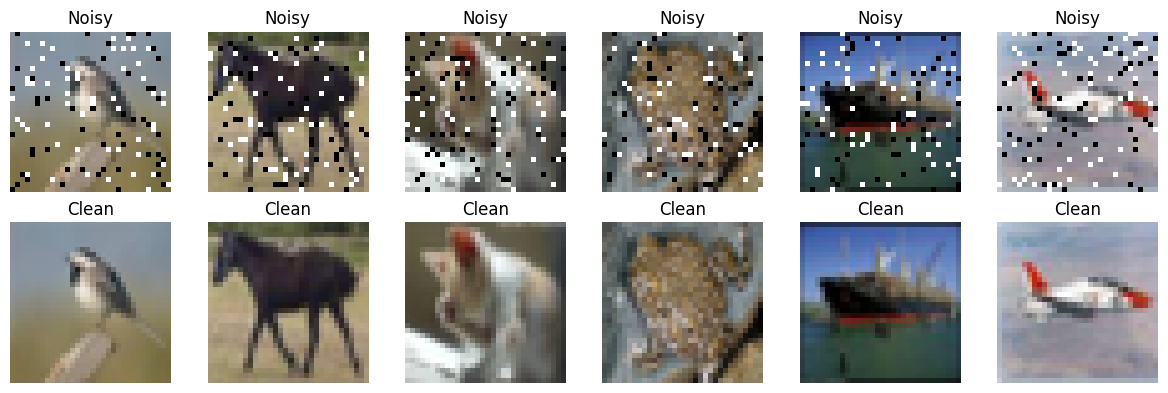

In [18]:
def unnormalize(img, mean, std):
    img = img * std[:, None, None] + mean[:, None, None]
    return img.clamp(0, 1)

examples = iter(train_loader)
samples, labels = next(examples)

plt.figure(figsize=(12, 4))
for i in range(6):
    # Noisy
    ax = plt.subplot(2, 6, i + 1)
    ax.imshow(unnormalize(samples[i], mean, std).permute(1, 2, 0).numpy())
    ax.set_title("Noisy")
    ax.axis('off')

    # Clean
    ax = plt.subplot(2, 6, i + 7)
    ax.imshow(unnormalize(labels[i], mean, std).permute(1, 2, 0).numpy())
    ax.set_title("Clean")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [19]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        # Downsampling
        self.downs = nn.ModuleList()
        self.pools = nn.ModuleList()
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            self.pools.append(nn.MaxPool2d(2))
            in_channels = feature
        
        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Upsampling
        self.ups = nn.ModuleList()
        self.up_convs = nn.ModuleList()
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.up_convs.append(DoubleConv(feature*2, feature))

        # Final layer
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        # Down path
        for down, pool in zip(self.downs, self.pools):
            x = down(x)
            skip_connections.append(x)
            x = pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Up path
        skip_connections = skip_connections[::-1]
        for up, conv, skip in zip(self.ups, self.up_convs, skip_connections):
            x = up(x)
            if x.shape != skip.shape:
                x = F.interpolate(x, size=skip.shape[2:])
            x = torch.cat((skip, x), dim=1)
            x = conv(x)

        return self.final_conv(x)

In [ ]:
model = UNet(in_channels=3, out_channels=3).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#  ReduceLROnPlateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
)


patience = 3  
best_val_loss = float('inf')
no_improve_epochs = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    ## Training ##
    model.train()
    train_loss = 0.0
    for noisy_imgs, clean_imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)

        optimizer.zero_grad()
        outputs = model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)  # MSELoss
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    ## Validation ##
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for noisy_imgs, clean_imgs in tqdm(validation_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
            outputs = model(noisy_imgs)
            loss = criterion(outputs, clean_imgs)  # MSELoss
            val_loss += loss.item()

    avg_val_loss = val_loss / len(validation_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train MSE: {avg_train_loss:.6f}, Val MSE: {avg_val_loss:.6f}")
    
    scheduler.step(avg_val_loss)

    ## Early Stopping ##
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print("Early stopping triggered!")
            break


Epoch 1/20 - Validation: 100%|██████████| 313/313 [00:05<00:00, 61.07it/s]


Epoch [1/20] Train MSE: 0.053929, Val MSE: 0.015819


Epoch 2/20 - Validation: 100%|██████████| 313/313 [00:05<00:00, 56.25it/s]


Epoch [2/20] Train MSE: 0.022615, Val MSE: 0.009304


Epoch 3/20 - Validation: 100%|██████████| 313/313 [00:05<00:00, 55.37it/s]


Epoch [3/20] Train MSE: 0.017283, Val MSE: 0.011154


Epoch 4/20 - Validation: 100%|██████████| 313/313 [00:06<00:00, 51.53it/s]


Epoch [4/20] Train MSE: 0.013900, Val MSE: 0.006761


Epoch 5/20 - Validation: 100%|██████████| 313/313 [00:06<00:00, 50.98it/s]


Epoch [5/20] Train MSE: 0.011254, Val MSE: 0.006118


Epoch 6/20 - Validation: 100%|██████████| 313/313 [00:03<00:00, 79.80it/s]


Epoch [6/20] Train MSE: 0.009103, Val MSE: 0.005536


Epoch 7/20 - Validation: 100%|██████████| 313/313 [00:06<00:00, 48.20it/s]


Epoch [7/20] Train MSE: 0.008337, Val MSE: 0.004704


Epoch 8/20 - Validation: 100%|██████████| 313/313 [00:06<00:00, 50.90it/s]


Epoch [8/20] Train MSE: 0.007622, Val MSE: 0.004762


Epoch 9/20 - Validation: 100%|██████████| 313/313 [00:05<00:00, 59.09it/s]


Epoch [9/20] Train MSE: 0.007184, Val MSE: 0.004450


Epoch 10/20 - Validation: 100%|██████████| 313/313 [00:05<00:00, 55.65it/s]


Epoch [10/20] Train MSE: 0.006926, Val MSE: 0.004394


Epoch 11/20 - Validation: 100%|██████████| 313/313 [00:03<00:00, 80.71it/s]


Epoch [11/20] Train MSE: 0.006163, Val MSE: 0.004757


Epoch 12/20 - Validation: 100%|██████████| 313/313 [00:05<00:00, 57.84it/s]


Epoch [12/20] Train MSE: 0.006064, Val MSE: 0.004200


Epoch 13/20 - Validation: 100%|██████████| 313/313 [00:05<00:00, 60.85it/s]


Epoch [13/20] Train MSE: 0.005816, Val MSE: 0.004420


Epoch 14/20 - Validation: 100%|██████████| 313/313 [00:05<00:00, 57.90it/s]


Epoch [14/20] Train MSE: 0.005572, Val MSE: 0.003792


Epoch 15/20 - Validation: 100%|██████████| 313/313 [00:05<00:00, 61.03it/s]


Epoch [15/20] Train MSE: 0.005258, Val MSE: 0.003608


Epoch 16/20 - Validation: 100%|██████████| 313/313 [00:05<00:00, 61.61it/s]


Epoch [16/20] Train MSE: 0.005074, Val MSE: 0.003550


Epoch 17/20 - Validation: 100%|██████████| 313/313 [00:05<00:00, 57.97it/s]


Epoch [17/20] Train MSE: 0.004930, Val MSE: 0.003600


Epoch 18/20 - Validation: 100%|██████████| 313/313 [00:03<00:00, 83.80it/s]


Epoch [18/20] Train MSE: 0.004750, Val MSE: 0.003459


Epoch 19/20 - Validation: 100%|██████████| 313/313 [00:05<00:00, 59.50it/s]


Epoch [19/20] Train MSE: 0.004629, Val MSE: 0.003635


Epoch 20/20 - Validation: 100%|██████████| 313/313 [00:05<00:00, 57.72it/s]

Epoch [20/20] Train MSE: 0.004467, Val MSE: 0.003737


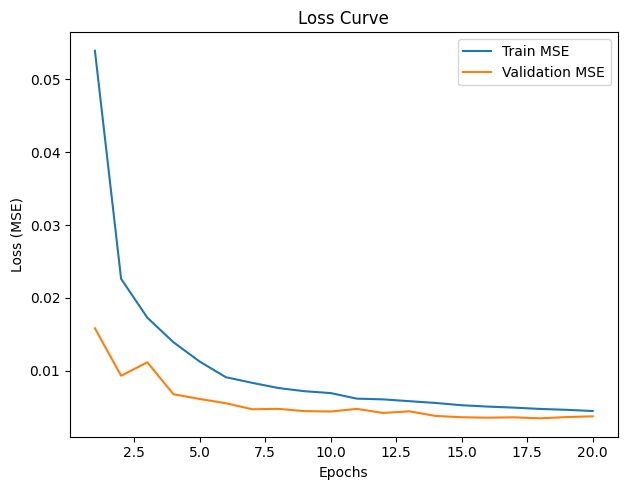

In [21]:
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, label='Train MSE')
plt.plot(epochs_range, val_losses, label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Loss Curve')
plt.legend()

plt.tight_layout()
plt.show()


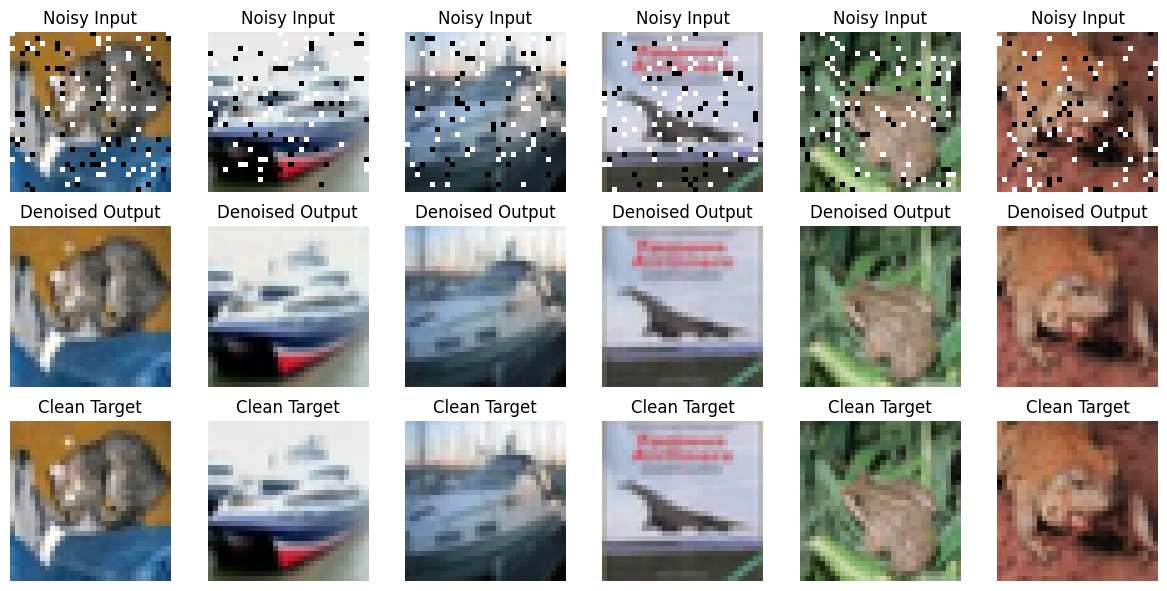

In [24]:
def unnormalize(img_tensor):
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1).to(img_tensor.device)
    std = torch.tensor([0.2470, 0.2430, 0.2610]).view(3,1,1).to(img_tensor.device)
    return img_tensor * std + mean

model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval()

examples = iter(test_loader)
noisy_imgs, clean_imgs = next(examples)
noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)

with torch.no_grad():
    outputs = model(noisy_imgs)

noisy_imgs = unnormalize(noisy_imgs).cpu()
clean_imgs = unnormalize(clean_imgs).cpu()
outputs = unnormalize(outputs).cpu()

plt.figure(figsize=(12,6))
for i in range(6):
    ax = plt.subplot(3,6,i+1)
    ax.imshow(np.clip(noisy_imgs[i].permute(1,2,0).numpy(), 0, 1))
    ax.set_title("Noisy Input")
    ax.axis("off")

    ax = plt.subplot(3,6,i+7)
    ax.imshow(np.clip(outputs[i].permute(1,2,0).numpy(), 0, 1))
    ax.set_title("Denoised Output")
    ax.axis("off")

    ax = plt.subplot(3,6,i+13)
    ax.imshow(np.clip(clean_imgs[i].permute(1,2,0).numpy(), 0, 1))
    ax.set_title("Clean Target")
    ax.axis("off")

plt.tight_layout()
plt.show()
